# The best of both worlds: Hierarchical Linear Regression in PyMC3

Today's blog post is co-written by my student [Danne Elbers](http://www.linkedin.com/pub/danne-elbers/69/3a2/7ba) who is doing her masters thesis with me on computational psychiatry using Bayesian methods. This post also borrows heavily from a [Notebook](http://nbviewer.ipython.org/github/fonnesbeck/multilevel_modeling/blob/master/multilevel_modeling.ipynb?create=1) by [Chris Fonnesbeck](http://biostat.mc.vanderbilt.edu/wiki/Main/ChrisFonnesbeck).

The power of Bayesian modelling really clicked for me when I was first introduced to hierarchical modelling. In this blog post we will highlight the advantage of using hierarchical Bayesian modelling as opposed to non-hierarchical Bayesian modelling. This hierachical modelling is especially advantageous when multi-level data is used, making the most of all information available by its 'shrinkage-effect', which will be explained below. 

Having multiple sets of measurements comes up all the time, in Psychology for example you test multiple subjects on the same task. You then might want to estimate a model that describes the behavior as a set of parameters relating to mental functioning. Often we are interested in individual differences of these parameters but also assume that subjects share similarities (being human and all). Software from our lab, [HDDM](http://ski.cog.brown.edu/hddm_docs/), allows hierarchical Bayesian estimation of a widely used decision making model but we will use a more classical example of hierarchical linear regression here to predict radon levels in houses.

This is the 3rd blog post on the topic of Bayesian modeling in PyMC3, see here for the previous two:

  * [The Inference Button: Bayesian GLMs made easy with PyMC3](https://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/)
  * [This world is far from Normal(ly distributed): Bayesian Robust Regression in PyMC3](https://twiecki.github.io/blog/2013/08/27/bayesian-glms-2/)  

## The data set
Gelman et al.'s (2007) radon dataset is a classic for hierarchical modeling. In this dataset the amount of the radioactive gas radon has been measured among different households in all county's of several states. Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to be more strongly present in households containing a basement and to differ in amount present among types of soil.
Here we'll investigate this differences and try to make predictions of radonlevels in different county's based on the county itself and the presence of a basement. In this example we'll look at Minnesota, a state that contains 85 county's in which different measurements are taken, ranging from 2 till 80 measurements per county. 

![radon](http://www.bestinspectionsllc.com/wp-content/uploads/2016/09/how-radon-enters-a-house-768x678.jpg)

First, we'll load the data: 

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd

data = pd.read_csv('radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values

The relevant part of the data we will model looks as follows:

In [3]:
data[['county', 'log_radon', 'floor']].head()

,county,log_radon,floor
0,AITKIN,0.832909,1.0
1,AITKIN,0.832909,0.0
2,AITKIN,1.098612,0.0
3,AITKIN,0.095310,0.0
4,ANOKA,1.163151,0.0


As you can see, we have multiple `radon` measurements (log-converted to be on the real line) in a `county` and whether the house has a basement (`floor` == 0) or not (`floor` == 1). We are interested in whether having a basement increases the `radon` measured in the house. 

## The Models

### Pooling of measurements
Now you might say: "That's easy! I'll just pool all my data and estimate one big regression to asses the influence of a basement across all counties". In math-speak that model would be:

$$radon_{i, c} = \alpha + \beta*\text{floor}_{i, c} + \epsilon$$ 

Where $i$ represents the measurement, $c$ the county and floor contains a yes (1) or no (0) to the question if the household has a basement. If you need a refresher on Linear Regressions in `PyMC`, check out my [previous blog post](https://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/). Critically, we are only estimating *one* intercept and *one* slope for all measurements over all counties.

### Separate regressions
But what if we are interested whether different counties actually have different relationships (slope) and different base-rates of radon (intercept)? Then you might say "OK then, I'll just estimate $n$ (number of counties) different regresseions -- one for each county". In math-speak that model would be:

$$radon_{i, c} = \alpha_{c} + \beta_{c}*\text{floor}_{i, c} + \epsilon_c$$

Note that we added the subindex $c$ so we are estimating $n$ different $\alpha$s and $\beta$s -- one for each county.

This is the extreme opposite model, where above we assumed all counties are exactly the same, here we are saying that they share no similarities whatsoever which ultimately is also unsatisifying.

### Hierarchical Regression: The best of both worlds

Fortunately there is a middle ground to both of these extreme views. Specifically, we may assume that while $\alpha$s and $\beta$s are different for each county, the coefficients all come from a common group distribution:

$$\alpha_{c} \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta_{c} \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}^2)$$

We thus assume the intercepts $\alpha$ and slopes $\beta$ to come from a normal distribution centered around their respective group mean $\mu$ with a certain standard deviation $\sigma^2$, the values (or rather posteriors) of which we also estimate. That's why this is called multilevel or hierarchical modeling.

How do we estimate such a complex model with all these parameters you might ask? Well, that's the beauty of Probabilistic Programming -- we just formulate the model we want and press our [Inference Button(TM)](https://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/). 

Note that the above is not a complete Bayesian model specification as we haven't defined priors or hyperpriors (i.e. priors for the group distribution, $\mu$ and $\sigma$). These will be used in the model implementation below but only distract here.

## Probabilistic Programming

### Individual/non-hierarchical model

To really highlight the effect of the hierarchical linear regression we'll first estimate the non-hierarchical Bayesian model from above (separate regressions). For each county a new estimate of the parameters is initiated. As we have no prior information on what the intercept or regressions could be we are placing a Normal distribution centered around 0 with a wide standard-deviation. We'll assume the measurements are normally distributed with noise $\epsilon$ on which we place a Half-Cauchy distribution.  

In [ ]:
# takes about 45 minutes
indiv_traces = {}
for county_name in county_names:
    # Select subset of data belonging to county
    c_data = data.ix[data.county == county_name]
    c_data = c_data.reset_index(drop=True)
    
    c_log_radon = c_data.log_radon
    c_floor_measure = c_data.floor.values
    
    with pm.Model() as individual_model:
        # Intercept prior
        a = pm.Normal('alpha', mu=0, sd=1)
        # Slope prior
        b = pm.Normal('beta', mu=0, sd=1)
    
        # Model error prior
        eps = pm.HalfCauchy('eps', beta=1)
    
        # Linear model
        radon_est = a + b * c_floor_measure
    
        # Data likelihood
        y_like = pm.Normal('y_like', mu=radon_est, sd=eps, observed=c_log_radon)

        # Inference button (TM)!
        trace = pm.sample(progressbar=False)
        
    indiv_traces[county_name] = trace

## Hierarchical Model
Instead of initiating the parameters separatly, the hierarchical model initiates group parameters that consider the county's not as completely different but as having an underlying similarity. These distributions are subsequently used to influence the distribution of each county's $\alpha$ and $\beta$.

In [16]:
with pm.Model() as hierarchical_model:
    # Hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=0., sd=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=1)
    mu_b = pm.Normal('mu_beta', mu=0., sd=1)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=1)
    
    # Intercept for each county, distributed around group mean mu_a
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=len(data.county.unique()))
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=len(data.county.unique()))
    
    # Model error
    eps = pm.HalfCauchy('eps', beta=1)
    
    # Expected value
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=radon_est, sd=eps, observed=data.log_radon)

In [17]:
with hierarchical_model:
    hierarchical_trace = pm.sample(njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:07<00:00, 126.84it/s]
/opt/miniconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.889237663849, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/opt/miniconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 2 does not match the target. It is 0.636029263947, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/opt/miniconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 2 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
/opt/miniconda/lib/pytho

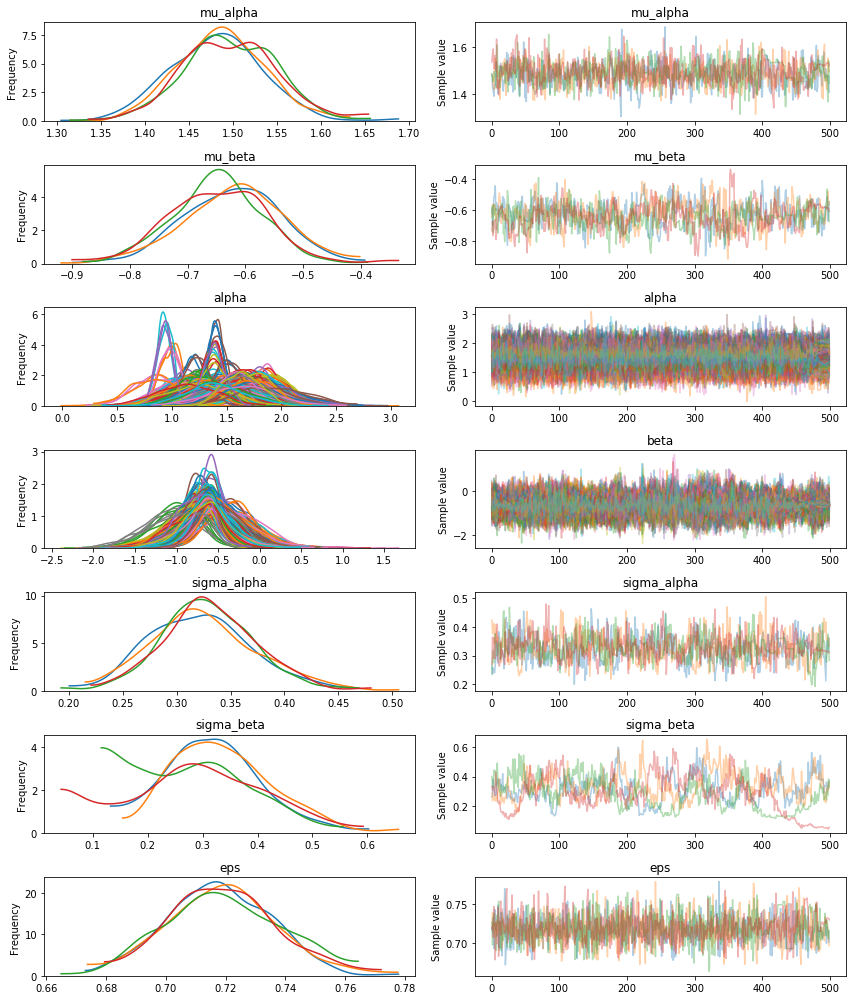

In [18]:
pm.traceplot(hierarchical_trace);

The marginal posteriors in the left column are highly informative. `mu_a` tells us the group mean (log) radon levels. `mu_b` tells us that having no basement decreases radon levels significantly (no mass above zero). We can also see by looking at the marginals for `a` that there is quite some differences in radon levels between counties; the different widths are related to how much measurements we have per county, the more, the higher our confidence in that parameter estimate.

<div class="alert alert-warning">

After writing this blog post I found out that the chains here (which look worse after I just re-ran them) are not properly converged, you can see that best for `sigma_beta` but also the warnings about "diverging samples" (which are also new in PyMC3). If you want to learn more about the problem and its solution, see my more recent blog post <a href='https://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/'>"Why hierarchical models are awesome, tricky, and Bayesian"</a>.

</div>

## Posterior Predictive Check

### The Root Mean Square Deviation

To find out which of the models works better we can calculate the Root Mean Square Deviaton (RMSD). This posterior predictive check revolves around recreating the data based on the parameters found at different moments in the chain. The recreated or predicted values are subsequently compared to the real data points, the model that predicts data points closer to the original data is considered the better one. Thus, the lower the RMSD the better.

When computing the RMSD (code not shown) we get the following result:

  * individual/non-hierarchical model: 0.13
  * hierarchical model: 0.08

As can be seen above the hierarchical model performs a lot better than the non-hierarchical model in predicting the radon values. Following this, we'll plot some examples of county's showing the true radon values, the hierarchial predictions and the non-hierarchical predictions. 

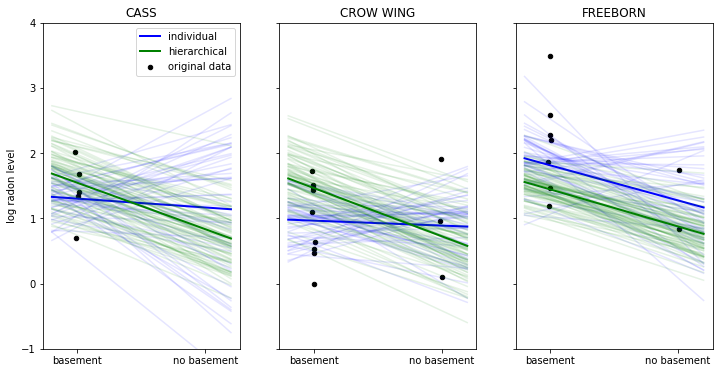

In [9]:
selection = ['CASS', 'CROW WING', 'FREEBORN']
fig, axis = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()
for i, c in enumerate(selection):
    c_data = data.ix[data.county == c]
    c_data = c_data.reset_index(drop = True)
    z = list(c_data['county_code'])[0]

    xvals = np.linspace(-0.2, 1.2)
    for a_val, b_val in zip(indiv_traces[c]['alpha'][::10], indiv_traces[c]['beta'][::10]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'b', alpha=.1)
    axis[i].plot(xvals, indiv_traces[c]['alpha'][::10].mean() + indiv_traces[c]['beta'][::10].mean() * xvals, 
                 'b', alpha=1, lw=2., label='individual')
    for a_val, b_val in zip(hierarchical_trace['alpha'][::10][z], hierarchical_trace['beta'][::10][z]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'g', alpha=.1)
    axis[i].plot(xvals, hierarchical_trace['alpha'][::10][z].mean() + hierarchical_trace['beta'][::10][z].mean() * xvals, 
                 'g', alpha=1, lw=2., label='hierarchical')
    axis[i].scatter(c_data.floor + np.random.randn(len(c_data))*0.01, c_data.log_radon, 
                    alpha=1, color='k', marker='.', s=80, label='original data')
    axis[i].set_xticks([0,1])
    axis[i].set_xticklabels(['basement', 'no basement'])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    if not i%3:
        axis[i].legend()
        axis[i].set_ylabel('log radon level')

In the above plot we have the data points in black of three selected counties. The thick lines represent the mean estimate of the regression line of the individual (blue) and hierarchical model (in green). The thinner lines are regression lines of individual samples from the posterior and give us a sense of how variable the estimates are.

When looking at the county 'CASS' we see that the non-hierarchical estimation is strongly biased: as this county's data contains only households with a basement the estimated regression produces the non-sensical result of a giant negative slope meaning that we would expect negative radon levels in a house without basement!

Moreover, in the example county's 'CROW WING' and 'FREEBORN' the non-hierarchical model appears to react more strongly than the hierarchical model to the existance of outliers in the dataset. Assuming that there should be a higher amount of radon gas measurable in households with basements opposed to those without, the county 'CROW WING''s non-hierachical model seems off. Having the group-distribution constrain the coefficients we get meaningful estimates in all cases as we apply what we learn from the group to the individuals and vice-versa.

# Shrinkage
Shrinkage describes the process by which our estimates are "pulled" towards the group-mean as a result of the common group distribution -- county-coefficients very far away from the group mean have very low probability under the normality assumption. In the non-hierachical model every county is allowed to differ completely from the others by just using each county's data, resulting in a model more prone to outliers (as shown above). 

In [10]:
hier_a = hierarchical_trace['alpha'].mean(axis=0)
hier_b = hierarchical_trace['beta'].mean(axis=0)
indv_a = [indiv_traces[c]['alpha'].mean() for c in county_names]
indv_b = [indiv_traces[c]['beta'].mean() for c in county_names]

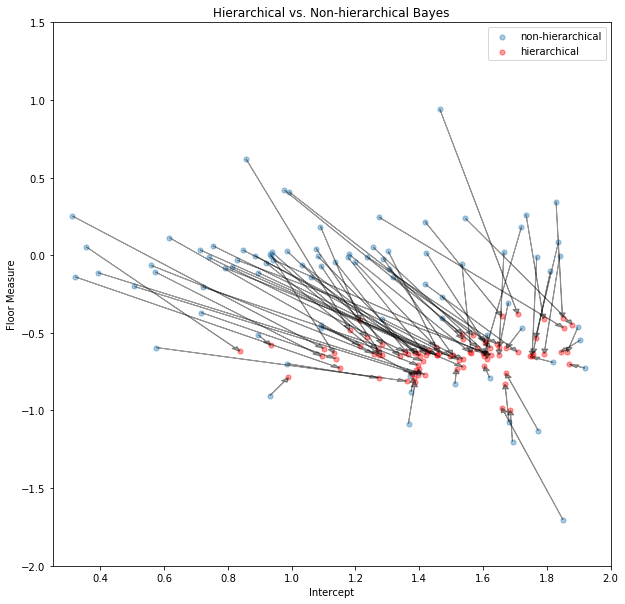

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, xlabel='Intercept', ylabel='Floor Measure', 
                     title='Hierarchical vs. Non-hierarchical Bayes', 
                     xlim=(0.25, 2), ylim=(-2, 1.5))

ax.scatter(indv_a,indv_b, s=26, alpha=0.4, label = 'non-hierarchical')
ax.scatter(hier_a,hier_b, c='red', s=26, alpha=0.4, label = 'hierarchical')
for i in range(len(indv_b)):  
    ax.arrow(indv_a[i], indv_b[i], hier_a[i] - indv_a[i], hier_b[i] - indv_b[i], 
             fc="k", ec="k", length_includes_head=True, alpha=0.4, head_width=.02)
ax.legend();

In the shrinkage plot above we show the coefficients of each county's non-hierarchical posterior mean (blue) and the hierarchical posterior mean (red). To show the effect of shrinkage on a single coefficient-pair (alpha and beta) we connect the blue and red points belonging to the same county by an arrow. Some non-hierarchical posteriors are so far out that we couldn't display them in this plot (it makes the axes to wide). Interestingly, all hierarchical posteriors of the floor-measure seem to be around -0.6 indicating that having a basement in almost all county's is a clear indicator for heightend radon levels. The intercept (which we take for type of soil) appears to differ among county's. This information would have been difficult to find when just the non-hierarchial model had been used. 

# Summary

In this post, co-authored by Danne Elbers, we showed how a multi-level hierarchical Bayesian model gives the best of both worlds when we have multiple sets of measurements we expect to have similarity. The naive approach either pools all data together and ignores the individual differences, or treats each set as completely separate leading to noisy estimates as shown above. By placing a group distribution on the individual sets we can learn about each set and the group simultaneously. Probabilistic Programming in PyMC then makes Bayesian estimation of this model trivial.


## References
  * [The Inference Button: Bayesian GLMs made easy with PyMC3](https://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/)
  * [This world is far from Normal(ly distributed): Bayesian Robust Regression in PyMC3](https://twiecki.github.io/blog/2013/08/27/bayesian-glms-2/)  
  * [Chris Fonnesbeck repo containing a more extensive analysis](https://github.com/fonnesbeck/multilevel_modeling/)
  * [Shrinkage in multi-level hierarchical models](http://doingbayesiandataanalysis.blogspot.com/2012/11/shrinkage-in-multi-level-hierarchical.html) by John Kruschke
  * Gelman, A.; Carlin; Stern; and Rubin, D., 2007, "Replication data for: Bayesian Data Analysis, Second Edition", 
  * Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.
  * Gelman, A. (2006). Multilevel (Hierarchical) modeling: what it can and cannot do. Technometrics, 48(3), 432–435.